<a href="https://colab.research.google.com/github/zach401/acnsim_baseline_comparison/blob/master/unbalanced_three_phase_infrastructure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*If running in Colab run this first to install ACN-Portal.*

In [0]:
!git clone https://github.com/zach401/acnportal.git
!pip install acnportal/.

# Unbalanced Three-Phase Infrastructure Constraints

Currently, most charging algorithms in the literature rely on constraints which assume single-phase or balanced three-phase operation. In this experiment, we demonstrate why these assumptions are insufficient for practical charging systems. 

For this experiment we use the LLF algorithm. We consider two cases. In the first, LLF considers a simplified single-phase representation of the constraints in the network. In the second, LLF uses the full three-phase system model. In both cases, we evalaute the algorithms using the true three-phase network model.

In [0]:
import pytz
from datetime import datetime
import numpy as np
import cvxpy as cp
from copy import deepcopy
import time 
from matplotlib import pyplot as plt

from acnportal import acnsim
from acnportal.acnsim import ChargingNetwork
from acnportal.acnsim import Current
from acnportal.acnsim import get_evse_by_type
from acnportal.acnsim import analysis
from acnportal import algorithms
from acnportal.algorithms import BaseAlgorithm

## Single-phase CaltechACN Network

In this *ChargingNetwork* we treat all EVSEs as if they were on the same phase by setting the phase angle for each to be 0. The only constraints for this model are that the aggregate rates of the AV and CC pods are less than 80 A and that the aggregate power of all EVSEs is less than the power limit of the transformer. 

(We assume nominal voltage in the network)

In [0]:
class SinglePhaseCaltechACN(ChargingNetwork):
    """ Predefined ChargingNetwork for the Caltech ACN.

    Args:
        basic_evse (bool): If True use BASIC EVSE type instead of actual AeroViroment and ClipperCreek types.
        voltage (float): Default voltage at the EVSEs. Does not affect the current rating of the transformer which is
            based on nominal voltages in the network. 277V LL for delta primary and 120V LN for wye secondary. [V]
        transformer_cap (float): Capacity of the transformer in the CaltechACN. Default: 150. [kW]

    Attributes:
        See ChargingNetwork for Attributes.
    """
    def __init__(self, basic_evse=False, voltage=208, transformer_cap=150):
        super().__init__()

        if basic_evse:
            evse_type = {'AV': 'BASIC', 'CC': 'BASIC'}
        else:
            evse_type = {'AV': 'AeroVironment', 'CC': 'ClipperCreek'}

        # Define the sets of EVSEs in the Caltech ACN.
        CC_pod_ids = ['CA-322', 'CA-493', 'CA-496', 'CA-320', 'CA-495', 'CA-321', 'CA-323', 'CA-494']
        AV_pod_ids = ['CA-324', 'CA-325', 'CA-326', 'CA-327', 'CA-489', 'CA-490', 'CA-491', 'CA-492']
        AB_ids = ['CA-{0}'.format(i) for i in [308, 508, 303, 513, 310, 506, 316, 500, 318, 498]] + CC_pod_ids + AV_pod_ids
        BC_ids = ['CA-{0}'.format(i) for i in [304, 512, 305, 511, 313, 503, 311, 505, 317, 499]]
        CA_ids = ['CA-{0}'.format(i) for i in [307, 509, 309, 507, 306, 510, 315, 501, 319, 497, 312, 504, 314, 502]]

        # Temporarily add ADA spaces to BC, since we don't know where they come from
        BC_ids += ['CA-148', 'CA-149', 'CA-212', 'CA-213']

        # Add Caltech EVSEs
        for evse_id in AB_ids:
            if evse_id not in CC_pod_ids:
                self.register_evse(get_evse_by_type(evse_id, evse_type['AV']), voltage, 0)
            else:
                self.register_evse(get_evse_by_type(evse_id, evse_type['CC']), voltage, 0)
        for evse_id in BC_ids:
            self.register_evse(get_evse_by_type(evse_id, evse_type['AV']), voltage, 0)
        for evse_id in CA_ids:
            self.register_evse(get_evse_by_type(evse_id, evse_type['AV']), voltage, 0)

        # Add Caltech Constraint Set
        CC_pod = Current(CC_pod_ids)
        AV_pod = Current(AV_pod_ids)
        all_current = Current(AB_ids + BC_ids + CA_ids)

        # Build constraint set
        self.add_constraint(CC_pod, 80, name='CC Pod')
        self.add_constraint(AV_pod, 80, name='AV Pod')
        self.add_constraint(all_current, transformer_cap * 1000 / voltage, name='Transformer Cap')

## Experiment Setup

In [0]:
# -- Experiment Parameters ---------------------------------------------------------------------------------------------
timezone = pytz.timezone('America/Los_Angeles')
start = timezone.localize(datetime(2019, 3, 5))
end = timezone.localize(datetime(2019, 3, 6))
period = 5  # minute
voltage = 208  # volts
default_battery_power = 32 * voltage / 1000 # kW
site = 'caltech'

# -- Network -----------------------------------------------------------------------------------------------------------
single_phase_cn = SinglePhaseCaltechACN(basic_evse=True, transformer_cap=50)
real_cn = acnsim.sites.CaltechACN(basic_evse=True, transformer_cap=50)

# -- Events ------------------------------------------------------------------------------------------------------------
API_KEY = 'DEMO_TOKEN'
events = acnsim.acndata_events.generate_events(API_KEY, site, start, end, period, voltage, default_battery_power)

## Running Experiment

### Single-Phase

In [0]:
llf_sp_sim = acnsim.Simulator(deepcopy(single_phase_cn), 
                              algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first),
                              deepcopy(events), start, period=period, 
                              max_recomp=1, verbose=False)
llf_sp_sim.run()

### Three-Phase

In [0]:
llf_tp_sim = acnsim.Simulator(deepcopy(real_cn), 
                              algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first),
                              deepcopy(events), start, period=period, 
                              max_recomp=1, verbose=False)
llf_tp_sim.run()

## Results

In order to compare the single-phase and three-phase versions of LLF, we plot the aggregate power of all EVSEs as well as individual line currents on the primary and secondary side of the transformer which feeds the CaltechACN. 

Since we are interested in how the single-phase LLF algorithm would have performed in the real CaltechACN, we replace the network model with the real network model for analysis. 

In [0]:
llf_sp_sim.network = real_cn

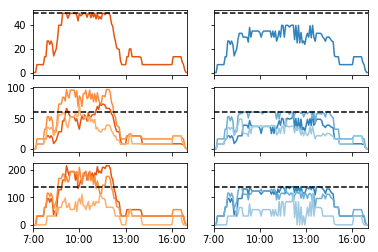

In [9]:
from matplotlib import cm
cmap = cm.get_cmap('tab20c')

fig, axes = plt.subplots(3, 2, sharey='row', sharex=True, figsize=(6,4))
fig.subplots_adjust(wspace=0.17, hspace=0.17)
axes[0, 0].set_xlim(7*12, 17*12)

# Plot Aggregate Charging Power
sp_agg = analysis.aggregate_current(llf_sp_sim)*voltage/1000
tp_agg = analysis.aggregate_current(llf_tp_sim)*voltage/1000
sp_color = 4
tp_color = 0
axes[0, 0].plot(sp_agg, color=cmap(sp_color))
axes[0, 1].plot(tp_agg, color=cmap(tp_color))


# Calculate currents in constrained lines
sp_cc = analysis.constraint_currents(llf_sp_sim)
tp_cc = analysis.constraint_currents(llf_tp_sim)

# Plot currents in lines on the Primary and Secondary side of the transformer.
for j, line in enumerate('ABC'): 
  axes[1, 0].plot(sp_cc['Primary {0}'.format(line)], label='Primary {0}'.format(line), color=cmap(j + sp_color))
  axes[1, 1].plot(tp_cc['Primary {0}'.format(line)], label='Primary {0}'.format(line), color=cmap(j + tp_color))

  axes[2, 0].plot(sp_cc['Secondary {0}'.format(line)], label='Secondary {0}'.format(line), color=cmap(j + sp_color))
  axes[2, 1].plot(tp_cc['Secondary {0}'.format(line)], label='Secondary {0}'.format(line), color=cmap(j + tp_color))

# Plot limits 
axes[0, 0].axhline(50, color='k', linestyle='--')
axes[1, 0].axhline(180.5/3, color='k', linestyle='--')
axes[2, 0].axhline(416.67/3, color='k', linestyle='--')

axes[0, 1].axhline(50, color='k', linestyle='--')
axes[1, 1].axhline(180.5/3, color='k', linestyle='--')
axes[2, 1].axhline(416.67/3, color='k', linestyle='--')

plt.xticks(range(7*12, 17*12, 36), ['7:00', '10:00', '13:00', '16:00'])
plt.show()

Here we can see that only considering single-phase constraints can lead to significant constraint violations in line currents. However, by designing an algorithm which considers the full three-phase model, we are able to respect these constraints. Note that because of phase unbalance, we are not able to make use of the full 50 kW transformer capacity while also respecting line limits.

In [0]:
from google.colab import files
fig.savefig("three-phase-llf.pdf", dpi=300)
files.download("three-phase-llf.pdf")